In [1]:
%matplotlib inline
import cartopy.crs as ccrs
import cartopy
cartopy.config['data_dir'] = "/home1/kojoseph/cartopy-data"
import xarray as xr
import xesmf as xe
import os
import matplotlib.pyplot as plt
import pyproj
import numpy as np
from osgeo import gdal
import rioxarray as rxr
import netCDF4

## Load WRF input data

In [2]:
# load WRF sample input file
wrf_file_path = '/project/banweiss_274/kojoseph/wrfinput_files/default_2015/wrfinput_d03_201501'
wrf_ds = xr.open_dataset(wrf_file_path)

In [3]:
# rename coordinates to lat/lon
wrf_ds = wrf_ds.rename({'XLAT':'lat', 'XLONG':'lon'})
wrf_ds = wrf_ds.squeeze('Time')
wrf_ds

<xarray.Dataset>
Dimensions:               (south_north: 141, west_east: 129, bottom_top: 29, bottom_top_stag: 30, soil_layers_stag: 4, west_east_stag: 130, south_north_stag: 142, DIM0009: 5, land_cat_stag: 33, soil_cat_stag: 16, urban_wind_directions_stag: 4, num_ext_model_couple_dom_stag: 1, dust_erosion_dimension: 3)
Coordinates:
    lat                   (south_north, west_east) float32 ...
    lon                   (south_north, west_east) float32 ...
    XLAT_U                (south_north, west_east_stag) float32 ...
    XLONG_U               (south_north, west_east_stag) float32 ...
    XLAT_V                (south_north_stag, west_east) float32 ...
    XLONG_V               (south_north_stag, west_east) float32 ...
Dimensions without coordinates: south_north, west_east, bottom_top, bottom_top_stag, soil_layers_stag, west_east_stag, south_north_stag, DIM0009, land_cat_stag, soil_cat_stag, urban_wind_directions_stag, num_ext_model_couple_dom_stag, dust_erosion_dimension
Data variables: (12/197)
    Times                 |S19 ...
    LU_INDEX              (south_north, west_east) float32 ...
    ZNU                   (bottom_top) float32 ...
    ZNW                   (bottom_top_stag) float32 ...
    ZS                    (soil_layers_stag) float32 ...
    DZS                   (soil_layers_stag) float32 ...
    ...                    ...
    DMS_0                 (south_north, west_east) float32 ...
    LAKEFLAG              int32 ...
    LAKE_DEPTH_FLAG       int32 ...
    LANDMASK              (south_north, west_east) float32 ...
    LAKEMASK              (south_north, west_east) float32 ...
    SST                   (south_north, west_east) float32 ...
Attributes: (12/72)
    TITLE:                            OUTPUT FROM REAL_EM V3.7 PREPROCESSOR
    START_DATE:                      2014-12-27_09:00:00
    SIMULATION_START_DATE:           2014-12-27_09:00:00
    WEST-EAST_GRID_DIMENSION:        130
    SOUTH-NORTH_GRID_DIMENSION:      142
    BOTTOM-TOP_GRID_DIMENSION:       30
    ...                              ...
    NUM_LAND_CAT:                    33
    ISWATER:                         16
    ISLAKE:                          -1
    ISICE:                           24
    ISURBAN:                         1
    ISOILWATER:                      14

In [4]:
# wrfinput_file_path = '/Users/josephko/USC/Research/Remote Sensing/wrf_files/wrfinput_d03_2015run_02_mod.nc'
# wrf_input = netCDF4.Dataset(wrfinput_file_path,'r+')
# wrf_input['ALBBCK'][:] = modis_ds_out_mod
# wrf_input.close() 

## Regrid GVF and modify wrfinput

In [5]:
# Load HDF-EOS file
modis_ndvi_filepath = '/scratch/kojoseph/modis/mod13a3/MOD13A3.A2016061.h08v05.006.2016110163108.hdf'
modis_ndvi = rxr.open_rasterio(modis_ndvi_filepath, masked=True)
modis_ndvi_transform = modis_ndvi.rio.transform()

# save transform parameters
x0 = modis_ndvi_transform[2]
xinc = modis_ndvi_transform[0]
y0 = modis_ndvi_transform[5]
yinc = modis_ndvi_transform[4]
nx, ny = (modis_ndvi.dims['x'], modis_ndvi.dims['y'])
x = np.linspace(x0, x0 + xinc*nx, nx)
y = np.linspace(y0, y0 + yinc*ny, ny)
xv, yv = np.meshgrid(x, y)

# get lat/lon
sinu = '+proj=sinu +R=6371007.181 +nadgrids=@null +wktext'
wgs84 = 'EPSG:4326' 
t = pyproj.Transformer.from_crs(sinu, wgs84, always_xy=True)
lon, lat = t.transform(xv, yv)
modis_ndvi = modis_ndvi.assign_coords({'lon': (['y', 'x'], lon),
                       'lat': (['y', 'x'], lat)})
modis_ndvi = modis_ndvi*0.01
modis_ndvi

<xarray.Dataset>
Dimensions:                              (y: 1200, x: 1200, band: 1)
Coordinates:
  * y                                    (y) float64 4.447e+06 ... 3.336e+06
  * x                                    (x) float64 -1.112e+07 ... -1.001e+07
  * band                                 (band) int64 1
    spatial_ref                          int64 0
    lon                                  (y, x) float64 -130.5 -130.5 ... -103.9
    lat                                  (y, x) float64 40.0 40.0 ... 30.0 30.0
Data variables:
    1 km monthly NDVI                    (band, y, x) float32 nan nan ... 20.24
    1 km monthly relative azimuth angle  (band, y, x) float32 nan nan ... -44.09
    1 km monthly pixel reliability       (band, y, x) float32 nan nan ... 0.0
    1 km monthly EVI                     (band, y, x) float32 nan nan ... 11.66
    1 km monthly VI Quality              (band, y, x) float32 nan nan ... 21.12
    1 km monthly red reflectance         (band, y, x) float32 nan nan ... 12.94
    1 km monthly NIR reflectance         (band, y, x) float32 nan nan ... 19.51
    1 km monthly blue reflectance        (band, y, x) float32 nan nan ... 7.52
    1 km monthly MIR reflectance         (band, y, x) float32 nan nan ... 24.15
    1 km monthly view zenith angle       (band, y, x) float32 nan nan ... 12.52
    1 km monthly sun zenith angle        (band, y, x) float32 nan nan ... 38.48
Attributes: (12/165)
    ALGORITHMPACKAGEACCEPTANCEDATE:      102004
    ALGORITHMPACKAGEMATURITYCODE:        Normal
    ALGORITHMPACKAGENAME:                MOD_PR13A3
    ALGORITHMPACKAGEVERSION:             5
    ASSOCIATEDINSTRUMENTSHORTNAME.1:     MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:       Terra
    ...                                  ...
    SOUTHBOUNDINGCOORDINATE:             29.9999999973059
    SPSOPARAMETERS:                      2749, 4334, 2749a, 4334a
    TileID:                              51008005
    VERSIONID:                           6
    VERTICALTILENUMBER:                  5
    WESTBOUNDINGCOORDINATE:              -130.540728914638

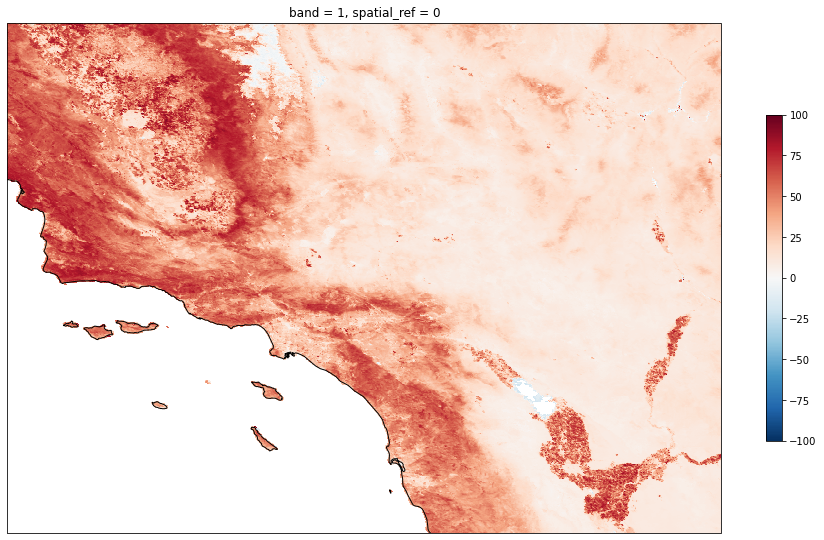

In [6]:
# plot NDVI to visualize
plot_data = modis_ndvi['1 km monthly NDVI']
fig = plt.figure(figsize=(8*2,12*2))
#ax = plt.axes(projection=ccrs.PlateCarree())
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-121, -114, 32, 37], crs=ccrs.PlateCarree())
ax.coastlines()
mesh = plot_data[0].plot.pcolormesh(ax = ax, x='lon' ,y='lat', add_colorbar=False, shading='auto')
fig.colorbar(mesh, shrink=0.25)

In [7]:
# create GVF data array 
modis_ndvi['gvf'] = modis_ndvi['1 km monthly NDVI']
modis_ndvi['gvf'] = modis_ndvi['gvf'].where(modis_ndvi['gvf']>0, other = 0)

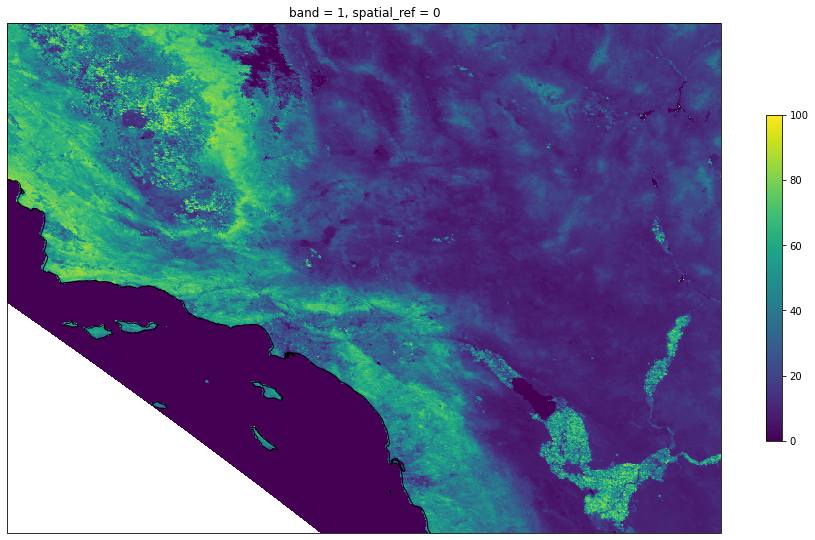

In [8]:
# plot gvf to visualize
plot_data = modis_ndvi['gvf']
fig = plt.figure(figsize=(8*2,12*2))
#ax = plt.axes(projection=ccrs.PlateCarree())
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-121, -114, 32, 37], crs=ccrs.PlateCarree())
ax.coastlines()
mesh = plot_data[0].plot.pcolormesh(ax = ax, x='lon' ,y='lat', add_colorbar=False, shading='auto')
fig.colorbar(mesh, shrink=0.25)

In [ ]:
# ### !!!!!!! IF FIRST TIME REGRIDDING !!!!!!!!!!!! ###
# regridder = xe.Regridder(modis_ndvi['gvf'], wrf_ds, 'bilinear', 
#                          filename='mod13_to_wrf_regrid_weights.nc')

In [9]:
# regrid to WRF grid
regridder_reuse = xe.Regridder(modis_ndvi['gvf'], wrf_ds,'bilinear', periodic=True, 
                               reuse_weights=True, filename='/scratch/kojoseph/modis/mod13_to_wrf_regrid_weights.nc')

modis_gvf_out = regridder_reuse(modis_ndvi['gvf'])
modis_gvf_out

# write regridded data as netcdf file
modis_gvf_out.to_netcdf(path = "gvf_regridded_test.nc", mode = 'w', )

/home1/kojoseph/.conda/envs/regrid_geo_sinu/lib/python3.8/site-packages/xarray/core/dataarray.py:784: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


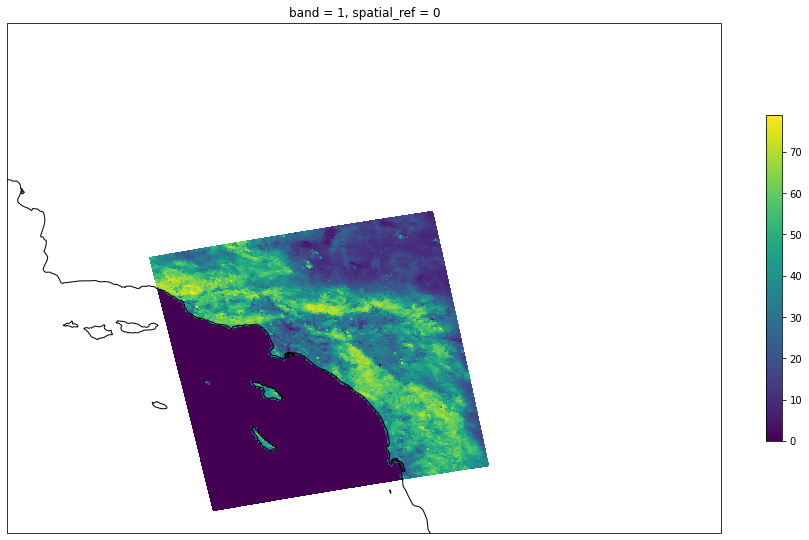

In [10]:
# plot regridded data to visualize
plot_data = modis_gvf_out
fig = plt.figure(figsize=(8*2,12*2))
#ax = plt.axes(projection=ccrs.PlateCarree())
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-121, -114, 32, 37], crs=ccrs.PlateCarree())
ax.coastlines()
mesh = plot_data[0].plot.pcolormesh(ax = ax, x='lon' ,y='lat', add_colorbar=False, shading='auto')
cbar = fig.colorbar(mesh, shrink=0.25)

In [ ]:
gvf_default = wrfinput_default['VEGFRA']
gvf_default

In [ ]:
landmask = wrfinput_default['LANDMASK']
landmask

In [ ]:
type(modis_ds_out)
modis_gvf_out_mod = modis_gvf_out.where(landmask!=0)
modis_gvf_out_mod = modis_gvf_out_mod.combine_first(gvf_default)
modis_gvf_out_mod

In [ ]:
wrfinput_file_path = '/Users/josephko/USC/Research/Remote Sensing/wrf_files/wrfinput_d03_2015run_02_mod.nc'
wrf_input = netCDF4.Dataset(wrfinput_file_path,'r+')
wrf_input['VEGFRA'][:] = modis_gvf_out_mod
wrf_input.close() 